# Identifying Themes in Anthony Bourdain's *Parts Unknown* 

## Using Non-negative Matrix Factorization and K-Means Clustering To Cluster Television Transcripts

### And also planning my next vacation...

Like many travelers I was deeply saddened by the death of travel personality Anthony Bourdain. An ongoing (and ridiculous) theme that I foist on those around me is pretending that Bourdain 'stole' my travel destinations. "Pfffff, he **WOULD** go to Armenia," I whine. But in reality, I greatly valued the always interesting and wonderfully humanistic viewpoint that Bourdain presented while exploring the world's complex places. I'll miss this viewpoint terribly, and in this project I applied NLP and clustering tools to identify overarching themes in Bourdain CNN television series *Parts Unknown*. 

[**Fair warning:** this post is long. Skip to the end if all you care about is what *Parts Unknown* is really about or where I'm going for my next vacation.]

## Data sources

I downloaded transcripts of the television show *Parts Unknown* from [OpenSubtitles](https://www.opensubtitles.org) and from [CNN](http://www.cnn.com/TRANSCRIPTS/abpu.html). Neither data source contained transcripts of all expisodes so I needed to use two different sources.

## Data extraction and formatting

My initial processing of transcripts from the two sources was tailored to the unique structure of the two transcript file types. For the OpenSubtitle files I processed with a modified script [here](https://gist.github.com/ndunn219/62263ce1fb59fda08656be7369ce329b) (modifications saved as the subtitle_lib module in this repo) and filtered the text to remove the intro theme song. For the CNN files, I used regex to remove narration indicators and a common 'transcript' words (things like 'translator' and 'voice-over') that appeared in this format.

After initial processing, both file types were combined into a data frame containing episode information and the full transcript text. You can find the full data set (including additonal meta data like episode air date and location) on my GitHub repo [here](add link to csv).

In [328]:
import nltk
import os, os.path
import pandas as pd
import glob
import re
import numpy as np
import math

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

## Data import
All of my intial data processing and subsequent cleaning can be found [here](https://github.com/katherinechandler/puk_nlp/blob/master/parts_unknown_nlp_full.ipynb). The raw and cleaned transcript text for 88 episodes was concatenated in a csv file containing additional metadata about each episode, including `episodeID`, `air_date`, and `episode_location`.

In [329]:
# import all concatenated data
puk = pd.DataFrame.from_csv('./puk_data/puk_all_episodes.csv')

In [330]:
# convert air_date as a date time object
puk.air_date = pd.to_datetime(puk.air_date)

## Tokenizers and stemming

I tested out a few different tokenizers to see how they deal with the data. I elected to use the `nltk.tokenize` tokenizer and the `PorterStemmer` for my text processing. Below is a function to tokenize and stem the words in the `clean_text` field of the episode data frame. The function returns two dictionaries of vocabulary: 1) `r_vocab` (`key` = episodeID, `value` = list of text as tokenized/stemmed strings), and 2) `global_vocab` (`key` = unique words in corpus, `values` = episodeID for each occurance of that word).

In [89]:
from nltk.stem.porter import PorterStemmer
import re
import string

st = PorterStemmer()

# define tokenizer and stem tokens using PorterStemmer to build a document vocabulary and corpus vocabulary
def tokenizer_stemmer(tokenizer):
    r_vocab = {}
    global_vocab = {}
    translator = str.maketrans(string.punctuation, ' '*32)

    for idx, episode in puk.iterrows():
        for token in tokenizer(episode.clean_text.translate(translator)):
            stemmed_token = st.stem(token.lower())
            if stemmed_token in global_vocab:
                global_vocab[stemmed_token].append(episode.episodeID)
            else:
                global_vocab[stemmed_token] = [episode.episodeID]
            if episode.episodeID in r_vocab:
                r_vocab[episode.episodeID].append(stemmed_token)
            else:
                r_vocab[episode.episodeID] = [stemmed_token]
    return r_vocab, global_vocab

In [90]:
# generating vocabulary dictionaries

r_vocab, global_vocab = tokenizer_stemmer(nltk.word_tokenize)

In [91]:
# set up list of tuples of episode, number of words, and unique number of words

words_episode = []
for episode in r_vocab.keys():
    words_episode.append((episode, len(r_vocab[episode]), len(set(r_vocab[episode]))))

# add tuples to DF and merge location name from 'episode_locations' data frame
episode_vocab_count = pd.DataFrame.from_records(words_episode)
episode_vocab_count.columns = ['episodeID', 'vocab_count', 'unique_vocab_count']
episode_vocab_count = episode_vocab_count.merge(puk, on='episodeID', how='left')
episode_vocab_count = episode_vocab_count[['air_date','episodeID', 
                                           'episode_location', 'vocab_count', 
                                           'unique_vocab_count']]

Looking at the words used across 'Parts Unknown' episodes, we see that episodes using the highest number of total words used were in the episodes filmed in West Virginia, London, and Los Angeles, and the highest number of unique words were in the episodes filmed in West Virginia, Los Angeles, and Montana. We also note that two episodes were filmed in Los Angeles (and have the same location name), thus the plot has an error bar. In general, the number of unique words used in each episode is consistent.

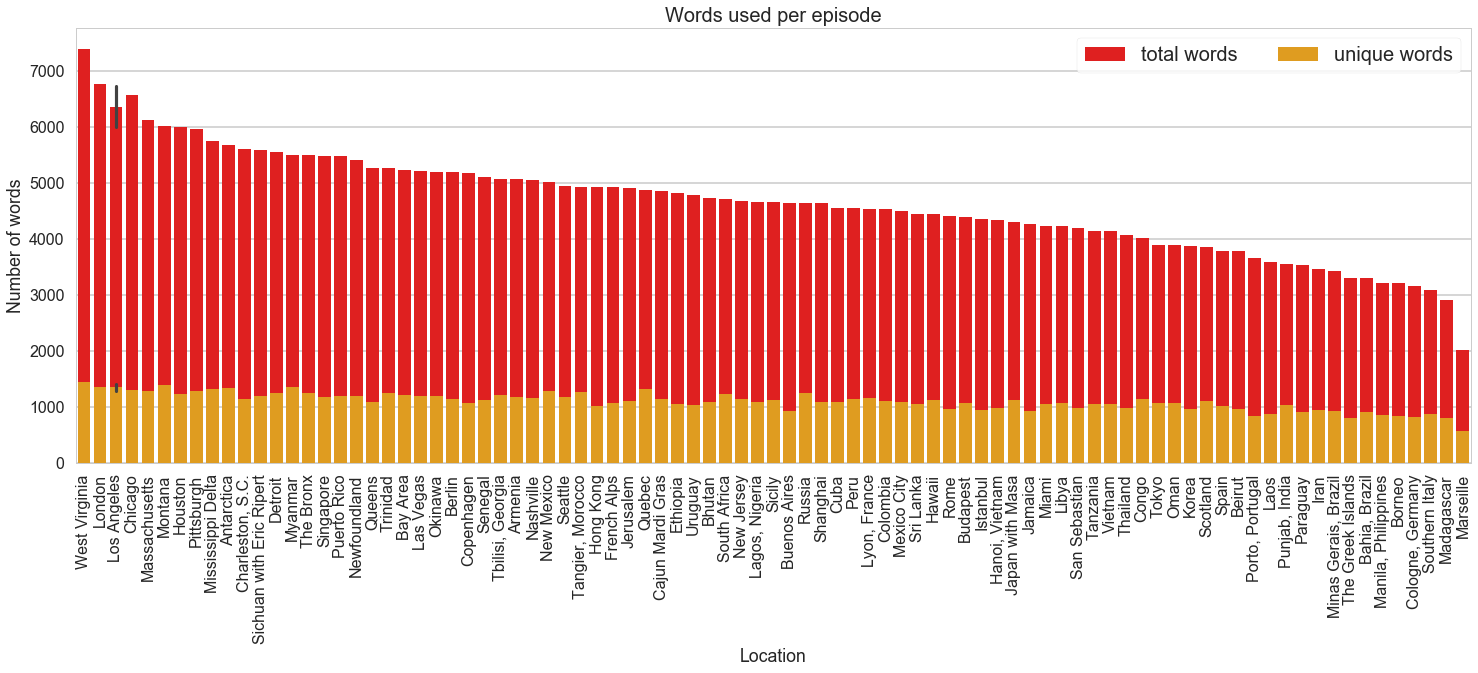

In [92]:
import seaborn as sns

sns.set_context(context='poster', font_scale=1)
fig, ax = plt.subplots(1, 1, figsize=(25,8))
sns.set(style="whitegrid")
                      
#plot total words per episode
sns.barplot(x="episode_location", y="vocab_count", 
            data=episode_vocab_count.sort_values('vocab_count', axis=0, ascending=False),
            color="red",
            label='total words')

#plot unique words per episode
sns.barplot(x="episode_location", y="unique_vocab_count", 
            data=episode_vocab_count.sort_values('vocab_count', axis=0, ascending=False),
            color="orange",
            label='unique words')

plt.setp(ax.get_xticklabels(), rotation=90)
ax.legend(ncol=2, loc="upper right", frameon=True, prop={'size': 20})
plt.title('Words used per episode', fontsize=20)
plt.ylabel('Number of words')
plt.xlabel('Location')

plt.show()

## Identifying and removing stopwords

The `nltk stopwords` list of stop words is not comprehensive, so I wanted to generate a more detailed list of commonly used words. I made a function to return a data frame containing the commonly occurring tokens that occur above a given threshold. As an approximation, I defined 'common words' as tokens that occur in the corpus more than 880 times (average of 10 times per episode X 88 episodes). I added these words to the default `nltk stopwords` to create a corpus specific stopword list (`puk_stopwords`). I also removed words that were 1-2 characters in length.

In [93]:
# returns words from provided vocab_count_list that occur above a certain threshold (num_occurances)
# returns df so occurances can be inspected

def id_common_words(vocab_count_list, num_occurances):
    word_counts = []
    for word in global_vocab:
        word_counts.append((word, len(vocab_count_list[word])))
    word_counts_df = pd.DataFrame.from_records(word_counts)
    word_counts_df.columns = ['word', 'number occurances']
    words_with_num_occurances = word_counts_df[word_counts_df['number occurances'] >= num_occurances]
    return(words_with_num_occurances)

In [94]:
# returns words from provided vocab_count_list that occur above a certain threshold (num_occurances)
# returns df so occurances can be inspected

def id_short_words(vocab_count_list, word_len):
    short_words = []
    for word in global_vocab:
        if len(word) <= word_len:
            short_words.append(word)
    return(short_words)

In [96]:
common_words = list((id_common_words(global_vocab, 880)).word)
short_words = id_short_words(global_vocab, 2)

In [97]:
from nltk.corpus import stopwords

# corpus specific stopwords

puk_stopwords = list(stopwords.words('english')) + common_words + short_words

In [98]:
# create list of words with and without stop words

all_vocab = list(global_vocab.keys())
vocab_std_stopwords = [w for w in all_vocab if w not in list(stopwords.words('english'))]
vocab_puk_stopwords = [w for w in all_vocab if w not in puk_stopwords]

print("The Parts Unknown 'corpus' contains {} words".format(len(all_vocab))) 
print("The Parts Unknown 'corpus' contains {} words not contained in standard stopwords".format(len(vocab_std_stopwords)))
print("The Parts Unknown 'corpus' contains {} words not contained in the corpus specific stopwords".format(len(vocab_puk_stopwords)))

The Parts Unknown 'corpus' contains 14057 words
The Parts Unknown 'corpus' contains 13933 words not contained in standard stopwords
The Parts Unknown 'corpus' contains 13675 words not contained in the corpus specific stopwords


## Exploring important words by episode

Before I dug into more rigorous corpus-wide analysis, I wanted to explore the words used in a few of my favorite episodes. To do this I calculated term frequency–inverse document frequency (TF-IDF), a measure of word importance in a particular document relative to all the documents in that corpus. Below is function that manually calculates TF-IDF and represents word frequencies in a word cloud.

In [ ]:
# Libraries
from wordcloud import WordCloud

# return wordcloud based on words common in episode but uncommon across corpus (tf-idf)

def tfidf_wordcloud(location, doc_vocab, corpus_vocab, corpus):    
    episodeID = corpus[corpus.episode_location == location].values[0][0]
    episode_tfidf = {}
    # compute tf-idf and save to dict 
    for token in doc_vocab[episodeID]:
        if not token in episode_tfidf:
            tf = np.log(1.*doc_vocab[episodeID].count(token)) + 1.
            idf = np.log(1. + len(corpus)*1. / len(set(corpus_vocab[token])) )
            episode_tfidf[token] = tf * idf
    wordcloud.generate_from_frequencies(frequencies=episode_tfidf)
    return(wordcloud)

# create a grid plot of some interesting locations

In [ ]:
# create a grid plot of some interesting locations

fig = plt.figure(figsize=(12,12))
places = ['Jerusalem', 'Myanmar', 'Armenia', 'Tokyo']
for i in range(len(places)):
    ax = fig.add_subplot(2,2,i+1)
    wordcloud = tfidf_wordcloud(places[i], r_vocab, global_vocab, puk)
    plt.title('{}'.format(places[i]), size=20)
    ax.imshow(wordcloud)
    ax.axis('off')

It was striking to see how much of these essence of these places was captured simply by performing TF-IDF. The words 'zionist', 'hamas', and 'falafel' are over represented in the Jerusalem episode, while the words 'censorship', 'tea', and 'mohinga' (a spicy fish soup) pretty much sum up Myanmar. The Armenian episode not only captures the conflict with Azerbaijan and the devestating 1992 earthquake, but touches on the country's obsession with chess. Japan, it seems, is mostly about 'porn', 'sushi', 'fetishes', and 'overwork'. 

## Using cosine similarity to identify similar locations

Examining an individual episode for important words isn’t that interesting, and I wanted to identify vocabulary similarities across episodes. One would expect, for example, that geographically or culturally related places like Southern Italy and Rome might contain a significant proportion of the same words.

To address these types of questions I vectorized the data using `sklearn TfidfVectorizer`. The ` TfidfVectorizer ` converts a collection of documents to a matrix of TF-IDF features. From the transformed tfidf vector I calculated a cosine similarity matrix to measure vocabulary similarities between the episodes. Cosine similarity is a measure of the cosine of the angle between two non-zero vectors and is thus a measure of similarity. Identical vectors will have an angle of 0° and a cosine similarity score of cosine(0°) = 1. In practice, cosine similarity is often represented as distance = 1- cosine_similarity, thus identical vectors would have a distance of 0. I calculated the distance measure from the cosine similarity matrix and plotted the result on a heat map.

In [106]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [107]:
# define data for the vectorizer and transformer functions
data = list(puk.clean_text)
episode_names = list(puk.episode_location)

In [108]:
# define data for the vectorizer and transformer functions
data = list(puk.clean_text)
episode_names = list(puk.episode_location)

# I need to address the fact that there are two LA episodes
episode_names[9] = 'Los Angeles_1'
episode_names[40] = 'Los Angeles_2'

In [109]:
# use tfidf vectorizer to vectorize and transform the data

tfidf_vectorizer = TfidfVectorizer(stop_words=set(puk_stopwords),
                                   smooth_idf=True,
                                   max_features=10000,
                                   max_df=60)

tfidf = tfidf_vectorizer.fit_transform(data)

In [110]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf)

In [111]:
# make df with similarity scores mapped to episodes 

cosine_sim = pd.DataFrame(dist, episode_names)
cosine_sim.columns = episode_names

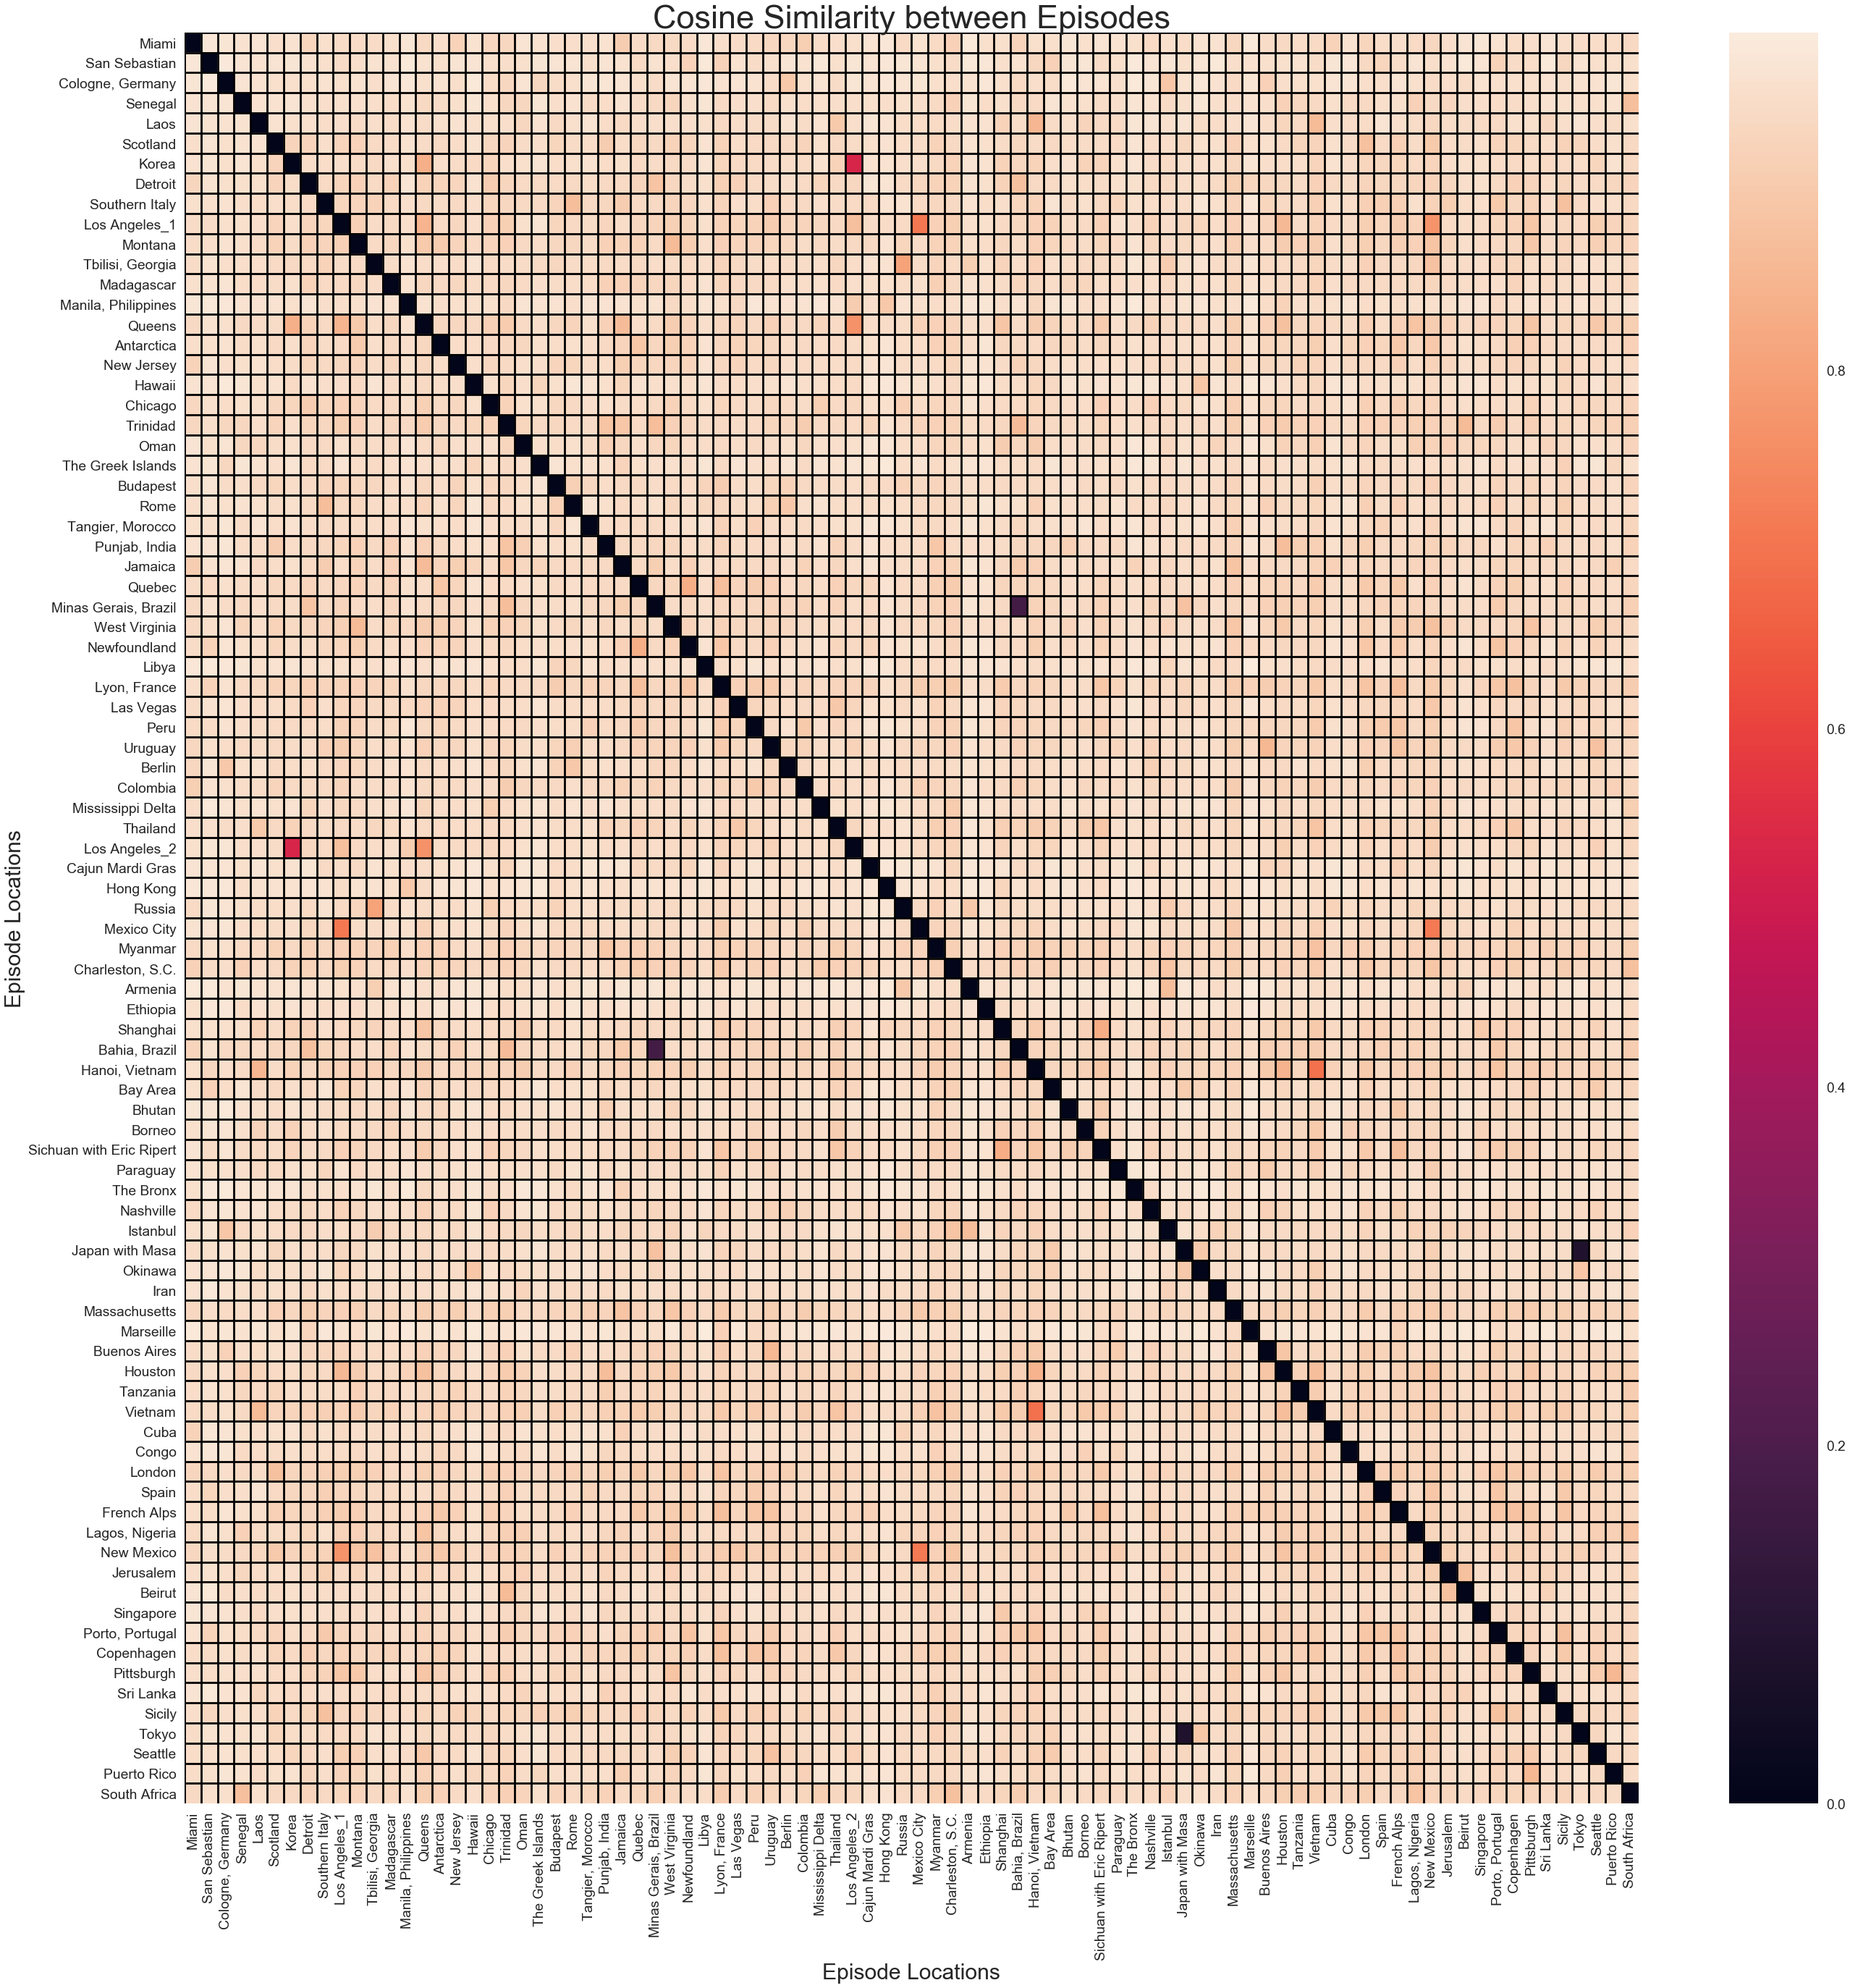

In [337]:
# Draw a heatmap with the numeric values in each cell

sns.set_context(context='poster', font_scale=1.2)

plt.subplots(figsize=(45,45))
ax = sns.heatmap(cosine_sim)
ax.hlines([range(len(cosine_sim))], *ax.get_xlim())
ax.vlines([range(len(cosine_sim))], *ax.get_ylim())
ax.set_xlabel('Episode Locations', size=30)
ax.set_ylabel('Episode Locations', size=30)
plt.title('Cosine Similarity between Episodes', size=45)
plt.setp(ax.get_xticklabels(), rotation=90)

plt.show()

The first thing that stands out with this heat map are the 4 strong purple points (dark purple represents a small distance between the episodes and thus higher similarity). Bourdain actually did two *Parts Unknown* episodes in Japan as well as two in Brazil, and not surprisingly these episodes use similar language. A number of other 'warm' spots were identified, and it's interesting to think about why Korea, LA, and Queens were identified as similar. 

To identify more unexpected connections between locations, I mapped the 3 most similar locations for each location using the cosine similarity score. While some of these associations didn't make sense, a surprising number of reasonable geographic and cultural/political relationships were identified.

For example, 'Southern Italy' was found to be related to Sicily (a region of Southern Italy), Rome (an Italian city), and Porto, Portugal (a southern European city). Regionally, these relationships make sense. 

Similarly, Russia was found to be most similar to Georgia, Armenia, and Istanbul. Russia, Georgia, and Armenia are all part of the former USSR, and Istanbul, Turkey is both geographically proximal and has an interconnected history with Armenia (which it borders) and Russia (a sometimes ally).

The Cuba episode was most similar to episodes located in Jamaica, Miami, and Hanoi, Vietnam. Cuba is geographically and culturally related to Jamaica and Miami, but the relationship with Hanoi, Vietnam is political. Both Cuba and Vietnam are socialist countries that have had conflicts with the United States, and Hanoi is the still the seat of the socialist party in Vietnam.

Below is a selection of interesting 'most related' locations.

In [123]:
# create a list of the 3 most similar locations for each location
list_similar = []

for column in cosine_sim:
    most_similar = cosine_sim.nsmallest(4, column).index
    similar = (most_similar[0], most_similar[1], most_similar[2], most_similar[3])
    list_similar.append(similar)

In [124]:
list_similar_df = pd.DataFrame.from_records(list_similar, columns=['location', 
                                                                   'similar_1',
                                                                   'similar_2', 
                                                                   'similar_3'])

In [125]:
print('Examples of Most similar locations based on cosine similarity of episode text:')
print(list_similar_df[list_similar_df.location == 'Korea'].values)
print(list_similar_df[list_similar_df.location == 'Detroit'].values)
print(list_similar_df[list_similar_df.location == 'Los Angeles_1'].values)
print(list_similar_df[list_similar_df.location == 'Russia'].values)
print(list_similar_df[list_similar_df.location == 'Okinawa'].values)
print(list_similar_df[list_similar_df.location == 'Southern Italy'].values)
print(list_similar_df[list_similar_df.location == 'Laos'].values)
print(list_similar_df[list_similar_df.location == 'Miami'].values)
print(list_similar_df[list_similar_df.location == 'Cuba'].values)
print(list_similar_df[list_similar_df.location == 'Hong Kong'].values)

Examples of Most similar locations based on cosine similarity of episode text:
[['Korea' 'Los Angeles_2' 'Queens' 'Thailand']]
[['Detroit' 'Bahia, Brazil' 'Minas Gerais, Brazil' 'Chicago']]
[['Los Angeles_1' 'Mexico City' 'New Mexico' 'Queens']]
[['Russia' 'Tbilisi, Georgia' 'Armenia' 'Istanbul']]
[['Okinawa' 'Hawaii' 'Tokyo' 'Japan with Masa']]
[['Southern Italy' 'Rome' 'Sicily' 'Porto, Portugal']]
[['Laos' 'Hanoi, Vietnam' 'Vietnam' 'Thailand']]
[['Miami' 'Jamaica' 'Colombia' 'Charleston, S.C.']]
[['Cuba' 'Hanoi, Vietnam' 'Jamaica' 'Miami']]
[['Hong Kong' 'Manila, Philippines' 'Shanghai' 'Hanoi, Vietnam']]


## Modeling Topics with Non-negative Matrix Factorization (NMF)

Now that I've identified some similiarities across the episode transcripts in the Parts Unknown corpus, I wanted to identify common themes. I used Non-negative Matrix factorization (NMF) to model theme clusters in the episodes of *Parts Unknown*. Below is a function to build a model and return the top `n` words for a given number of clusters `k` and for a transformed tfidf matrix.

In [126]:
# get words from vectorizer and map back to NMF model; 
# modified from https://medium.com/ml2vec/topic-modeling-is-an-unsupervised-learning-approach-to-clustering-documents-to-discover-topics-fdfbf30e27df

from sklearn.decomposition import NMF

def get_nmf_topics(model, vectorizer, num_topics, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    
    n_top_words = -1 * n_top_words
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:n_top_words - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Theme # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict)

In [158]:
# define stemmer and tokenizer and fit TfidfVectorizer

stemmer = PorterStemmer()

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text.translate(translator))
    stems = stem_tokens(tokens, stemmer)
    return stems

In [159]:
# generate a token dict with episode name as key

token_dict = {}

for idx, episode in puk.iterrows():
    episode_name = episode.episodeID
    text = episode.clean_text
    lowers = text.lower()
    no_punctuation = lowers.translate(string.punctuation)
    token_dict[episode_name] = no_punctuation

In [129]:
# use tfidf vectorizer to vectorize and transform the data

tfidf_vectorizer = TfidfVectorizer(tokenizer=tokenize, 
                                   stop_words=puk_stopwords,
                                   smooth_idf=False,
                                   max_features=10000,
                                   max_df=60,
                                   ngram_range=(1,3))

tfs = tfidf_vectorizer.fit_transform(token_dict.values())

# fit NMF model
model = NMF(n_components=10, init='nndsvd', random_state=42)

W = model.fit_transform( tfs )
H = model.components_

# get top 10 topics 
print('High TF-IDF Score Words by Theme:')
get_nmf_topics(model, tfidf_vectorizer, 10, 15)

High TF-IDF Score Words by Theme:


,Theme # 01,Theme # 02,Theme # 03,Theme # 04,Theme # 05,Theme # 06,Theme # 07,Theme # 08,Theme # 09,Theme # 10
0,chef,tokyo,brazil,korean,beirut,mexico,vietnam,berlin,miami,armenian
1,newfoundland,sushi,salvador,korea,africa,mexican,lao,rome,gon,russia
2,lyon,manga,caipirinha,han,india,new mexico,vietnames,itali,detroit,georgia
3,chocol,yasuda,brazilian,seoul,seneg,taco,noodl,bueno air,mississippi,putin
4,basqu,japanes,african,rockaway,congo,cartel,hanoi,cologn,puerto,armenia
5,chees,stanc,bahia,queen,oman,trejo,china,uruguay,bronx,russian
6,marseil,japan,inaud,game,trinidad,spanish,hue,bueno,beach,istanbul
7,quebec,inaud,world cup,sizzler,gaza,gun,rice,roman,chicago,turkey
8,eric,karat,pellorinio,koreatown,african,mescal,singapor,music,island,georgian
9,truffl,tentacl,capoeira,kimchi,palestinian,topito,thailand,mussolini,pittsburgh,soviet


The collection of words in 'Theme 1' didn't make sense to me initially, but I explored the episodes with high 'Theme 1' scores and noticed that these were destinations that Bourdain visited with other chefs. The episodes filmed in Sichuan, Peru, Marseille, and the French Alps were filmed with his friend Eric Ripert; the Newfoundland and Quebec episodes feature the chef duo Dave McMillan and Fred Morin; and the episodes filmed in Copenhagen (with chef Alessandro Porcelli), Lyon (with Daniel Boulud), San Sebastian (with Juan Mari and Elena Arzak), and London (various chefs). Food words like 'truffle', 'wine', and 'chocolate' occur regularly, and food preparation features prominently. I termed this theme `'foodie'`.

Themes 2 (`'japanese_weirdness'`), 3 (`'brazil_african'`), and 4 (`'korea'`) are clearly related to Japan, Brazil, and Korea respectively. 

Theme 5 (`'conflict_places'`) appears to be related to places of heightened conflict, like Beirut, Sri Lanka, and several African countries. 

Theme 6 (`'sw_tacos'`) represents Spanish-Mexican culture and is spread over many locations, including LA, Mexico City, Spain, Colombia, Houston, New Mexico. 

Theme 7 (`'se_asia'`) represents Asian food in general and South East Asian foods in particular, a Bourdain favorite. 

Theme 8 (`'random'`) has no discernable theme to me. 

Theme 9 (`'america'`) is loosely American. 

Finally, Theme 10 (`ussr&friends`) represents countries that were in the former USSR (Russia, Georgia, and Armenia) as well as culturally and geographically related neighbors (like Turkey).

NMF ranks each document as a mixture of the identified themes rather than as a single theme. Below is a heat map of how each location scores for each identified theme.

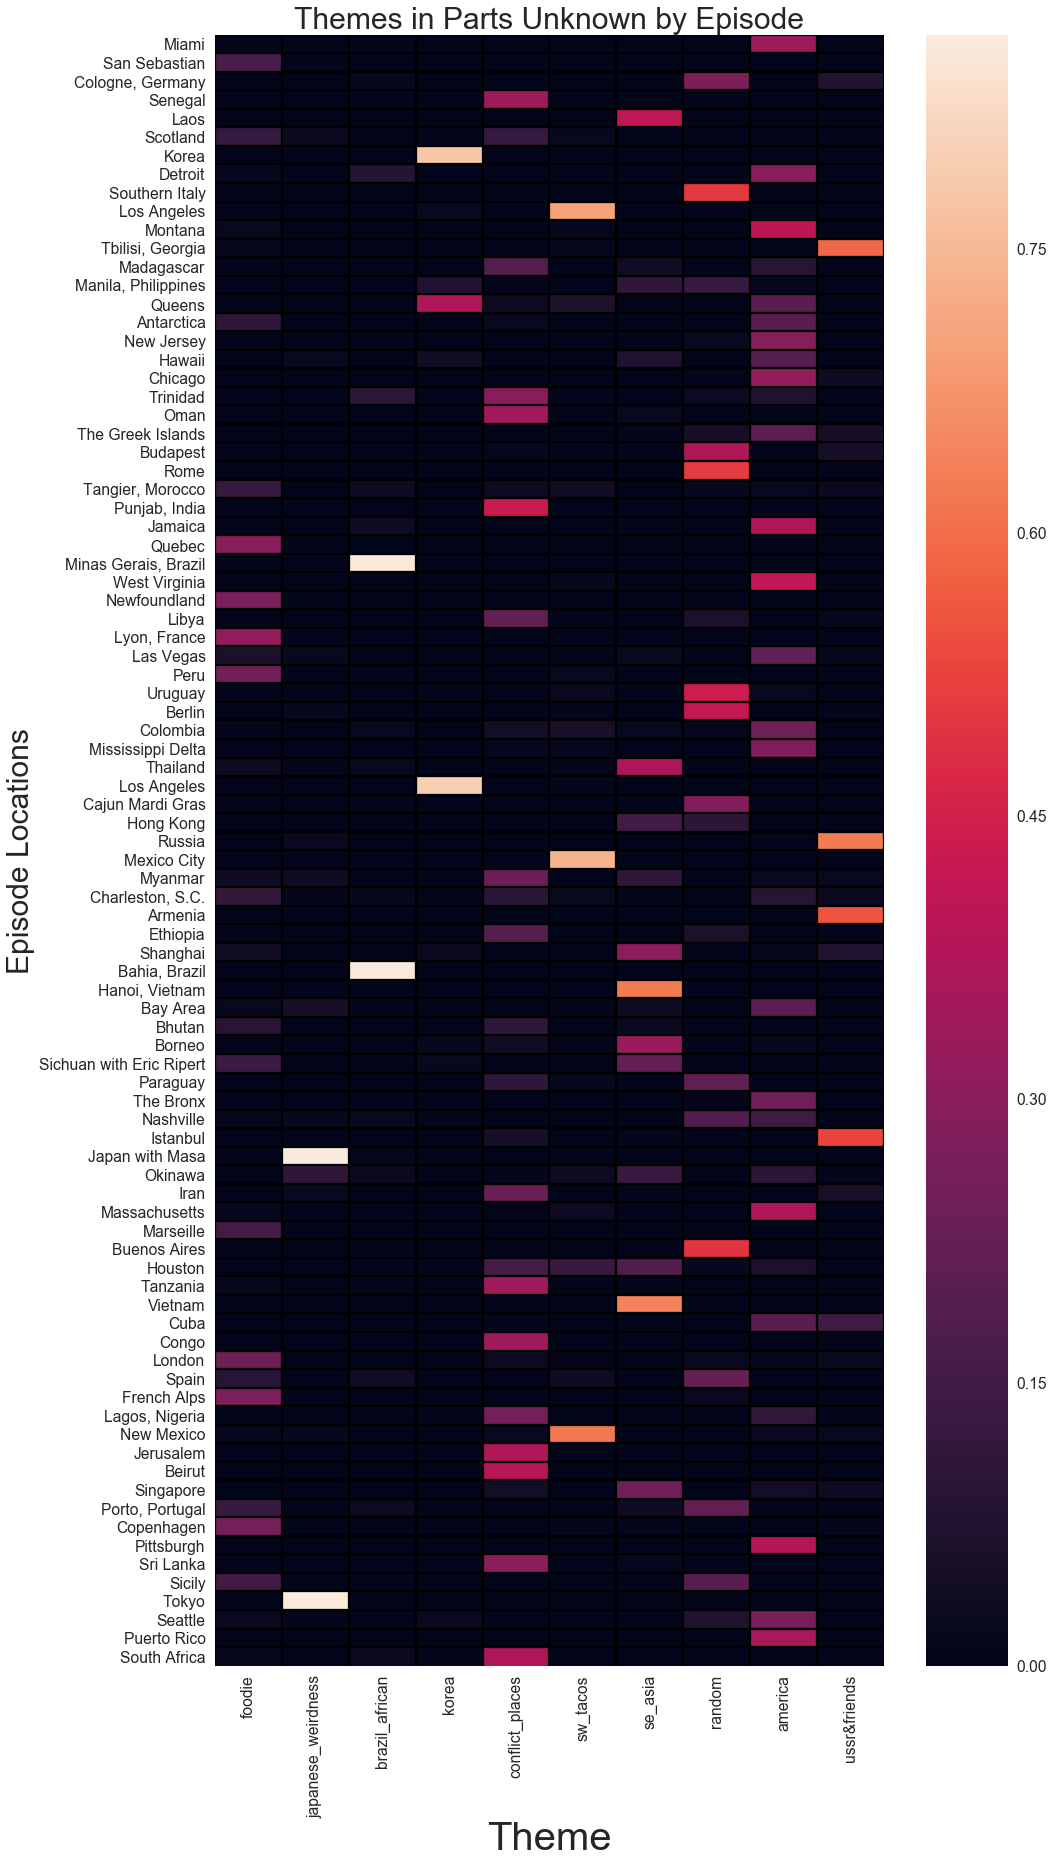

In [331]:
# save topics to df with labels

topic_names = ['foodie', 'japanese_weirdness', 'brazil_african', 'korea', 'conflict_places','sw_tacos', 
                'se_asia', 'random', 'america', 'ussr&friends']

topics = get_nmf_topics(model, tfidf_vectorizer, 10, 15)
topics.columns = topic_names

# set up df of episode scores by topics

episode_locations = puk.episode_location
episode_scores = pd.DataFrame(W,index=episode_locations)
episode_scores.columns = topic_names

sns.set_context(context='talk', font_scale=1.2)

# Draw a heatmap with the numeric values in each cell
plt.subplots(figsize=(15,30))
ax = sns.heatmap(episode_scores)
ax.hlines([range(len(episode_scores))], *ax.get_xlim())
ax.vlines([range(20)], *ax.get_ylim())
ax.set_xlabel('Theme', size=40 )
ax.set_ylabel('Episode Locations', size=30)
plt.title('Themes in Parts Unknown by Episode', size=30)
plt.setp(ax.get_xticklabels(), rotation=90)

plt.show()

## Generalizing the NMF model

I noticed that lots of the 'top words' in the topics were proper nouns like places, languages, and ethnicities. To identify more general topics, I added countries, cities, regions, continents, nationalities, and languages to my list of stopwords. The lists containing this information can be found in the supplemental_data folder of this [repo](https://github.com/katherinechandler/puk_nlp).

In [136]:
# read in csv with episode location information
place_names = pd.DataFrame.from_csv('supplemental_data/world-cities.csv',  index_col=None)

In [137]:
# list of countries

countries = list(place_names.country.unique())
countries = [i.lower() for i in countries]

In [138]:
# list of cities

cities = list(place_names.name.unique())
cities = [i.lower() for i in cities]

In [150]:
# list of subcountry (this includes some cities) 
# had to use isinstance since some characters aren't utf-8

import six
subcountry = list(place_names.subcountry.unique())
subcountry = [i.lower() for i in subcountry if isinstance(i, six.string_types)]

In [223]:
# list of nationalities

nationalities = pd.DataFrame.from_csv('supplemental_data/nationalities.csv',  index_col=None)

In [224]:
# identify nationalities and plural nationalities
nationalities = nationalities.columns
nationalities = [i.lower() for i in nationalities]
plural_nationalities = [i+'s' for i in nationalities]

In [225]:
# list of continents

continents = ['asia', 'africa', 'north' 'america', 'south', 'antarctica', 'europe', 'australia']
plural_continents = ['asian', 'african', 'north' 'american', 'south', 'antarctican', 'european', 'australian']

In [226]:
# additional place names not covered because of special characters or other reasons

exceptions = ['bogota', 'korea', 'korean', 'koreans','istanbul', 'lao', 'hawaiian', 'naxos', 'okinawan', 'bronx',
             'romans', 'vegas', 'cologne', 'glasgow', 'congo', 'puerto', 'rico', 'sri', 'lanka', 'lankan', 'britt', 
             'gonna', 'okinawans', 'atlantic', 'palestinian', 'buenos', 'aires', 'éric', 'eric', 'andy', '000',
             'queens', 'francisco', 'sicilian', 'newfoundland', 'chiang mai', 'chiang', 'mai', 'zamir', 'ricans',
             'braddock', 'blackwell', 'serj', 'jiu', 'jitsu', 'pelourinho', 'hue', 'hong', 'kong', 'antonio', 'port',
             'fred', 'conrad', 'john', 'bourdain', 'lynch', 'burrough', 'anton', 'marcu', 'alison', 'rockaway',
             'faulkner', 'sinatra', 'provincetown', 'caribbean']

In [227]:
puk_stopwords_expanded = (puk_stopwords + countries + cities + subcountry + 
                           nationalities + plural_nationalities + continents + 
                           plural_continents + exceptions)

In [228]:
tokenized_stopwords_expanded = tokenize((" ").join(puk_stopwords_expanded))

In [229]:
# join tokenized stopwords so they are also removed

puk_stopwords_expanded = puk_stopwords_expanded + tokenized_stopwords_expanded

In [186]:
# generate new tf-idf vector using expanded stopword list

tfidf = TfidfVectorizer(tokenizer=tokenize,
                        stop_words=set(puk_stopwords_expanded),
                        smooth_idf=False,
                        max_features=10000,
                        max_df=60,
                        ngram_range=(1,4))

tfs = tfidf.fit_transform(token_dict.values())

# fit NMF model to tfs
model_themes = NMF(n_components=10, random_state=42)

W_themes = model_themes.fit_transform( tfs )

# get topic components

get_nmf_topics(model_themes, tfidf, 10, 15)

,Theme # 01,Theme # 02,Theme # 03,Theme # 04,Theme # 05,Theme # 06,Theme # 07,Theme # 08,Theme # 09,Theme # 10
0,war,sushi,caipirinha,chef,noodl,yama,music,neighborhood,water,drug
1,putin,yasuda,inaud,chocol,rice,wine,record,taco,coal,heroin
2,soviet,stanc,world cup,truffl,chili,carniv,artist,tech,mile,cartel
3,gaddafi,inaud,pellorinio,chees,war,tapa,musician,panther,casino,addict
4,polit,karat,capoeira,cod,beer,mussolini,film,mom,waffl,violenc
5,sultan,tentacl,cachaca,wine,pork,pig,maya,race,cowboy,mescal
6,hezbollah,sex,instrument,wild,spici,mmm,studio,win,nativ,topito
7,revolut,tie,blowfish,bladder,squid,cave,writer,truck,barbecu,madam
8,religi,lurid,music,daniel,longhous,mardi,butcher,kimchi,pheasant,war drug
9,peac,demon,dend,flavor,karaok,mardi gra,gypsi,store,salad,kill


Removing place names from the vocabulary reveals general themes across the *Parts Unknown* corpus. Two location specific themes do emerge (Theme 2 is related to `'japanese_weirdness'` and Theme 3 is strongly Brazilian (`'caribbean_afro_influence'`), as well as two seemingly random themes (Theme 8 and Theme 9). 

The remaining themes, however, a fairly universal and highlight the overarching themes of *Parts Unknown*.

Theme 1 (`'conflict_areas'`) includes places of religious, political, and ideological tension. Episodes that score highly for this theme are Istanbul, Armenia, Beirut, Iran, and Sri Lanka. I find it interesting that in addition to the negative words associated with this theme, 'peace' and 'optimist' score highly in this topic.

Theme 4 (`'foodie'`) includes peaceful places where presumably Bourdain ate quite well. These episodes include Lyon (France), Quebec,  Newfoundland, and San Sebastian.

Theme 5 (`'asian_food'`) highlights Bourdain's love of Asian food, and is the only specific cuisine identified as a theme. I find it particularly satisfying that one of the top words for this category is 'mmm'. Locations scoring high for this theme are Thailand, Vietnam, Hong Kong and Singapore.

Theme 6 (`'euro'`) encompasses a span of European cities (and Buenos Aires, but hey, it's the Paris of South America). These top scoring locations are Southern Italy, Buenos Aires, Porto (Portugal and the Greek Islands. 

Themes 7 (`'music_art'`) is a general theme of music and art. The geographic reach of this topic is broad, with top locations being Berlin (strong arts scene), Nashville (strong music scene) and Tangier, Morocco (home to a huge number of writers during the 1920-1950's 'interzone' period).

Theme 10 (`'drugs'`) encompasses places related to the drug trade or with a prevalent drug culture. These locations include Mexico City, Colombia, and Massachusetts (major opioid crisis). 

Below is a heat map of how each location scores for each identified theme.

In [ ]:
sns.set_context(context='talk', font_scale=1.2)

# Draw a heatmap with the numeric values in each cell
plt.subplots(figsize=(15,30))
ax = sns.heatmap(episode_scores)
ax.hlines([range(len(episode_scores))], *ax.get_xlim())
ax.vlines([range(20)], *ax.get_ylim())
ax.set_xlabel('Theme', size=40 )
ax.set_ylabel('Episode Locations', size=30)
plt.title('Themes in Parts Unknown by Episode', size=40)
plt.setp(ax.get_xticklabels(), rotation=90)

plt.show()

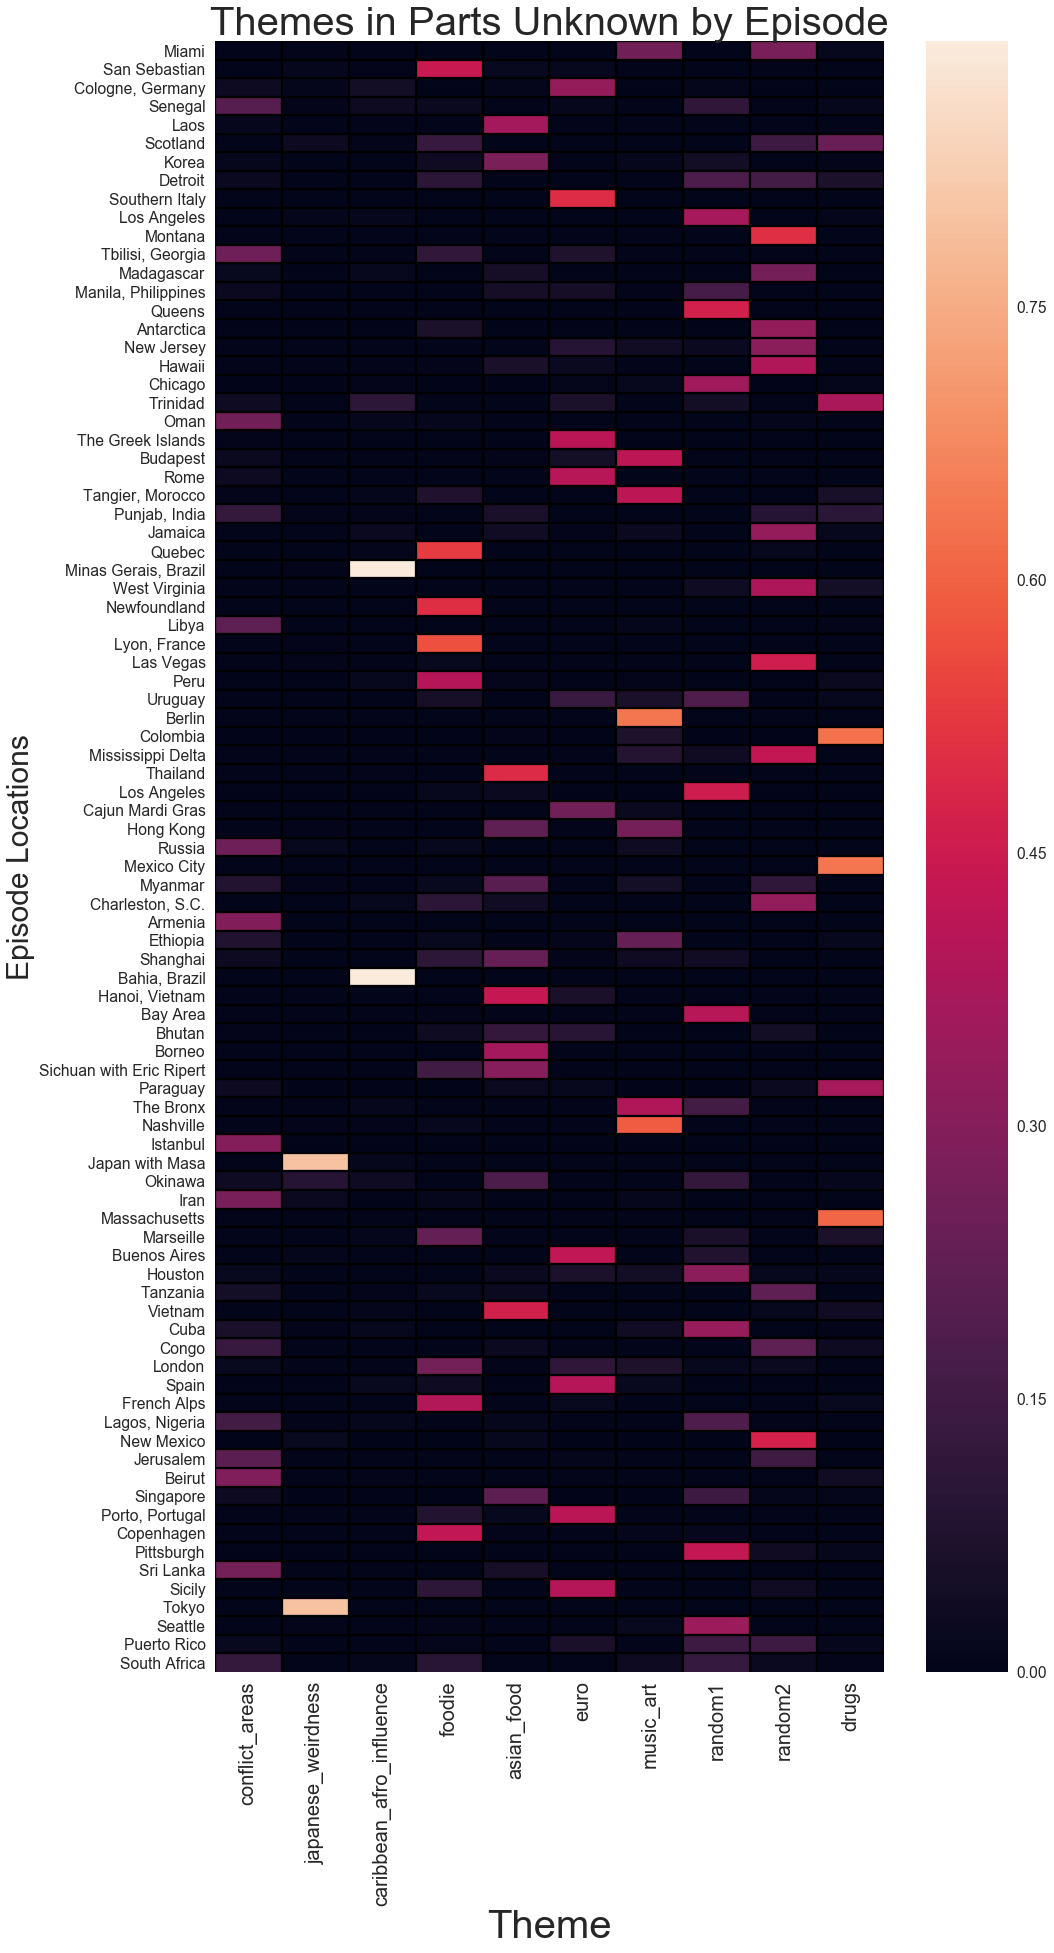

In [196]:
# save topics to df with labels

topic_names = ['conflict_areas', 'japanese_weirdness', 'caribbean_afro_influence', 'foodie', 
               'asian_food', 'euro', 'music_art', 'random1', 'random2', 'drugs']

# fit NMF model to tfs
model_themes = NMF(n_components=10, random_state=42)

W_themes = model_themes.fit_transform( tfs )

# get topic components

get_nmf_topics(model_themes, tfidf, 10, 10)

# set up df of episode scores by topics

episode_locations = puk.episode_location
episode_scores = pd.DataFrame(W_themes,index=episode_locations)
episode_scores.columns = topic_names

sns.set_context(context='talk', font_scale=1.2)
# Draw a heatmap with the numeric values in each cell
plt.subplots(figsize=(15,30))
ax = sns.heatmap(episode_scores)
ax.hlines([range(len(episode_scores))], *ax.get_xlim())
ax.vlines([range(20)], *ax.get_ylim())
ax.set_xlabel('Theme', size=40 )
ax.set_ylabel('Episode Locations', size=30)
plt.title('Themes in Parts Unknown by Episode', size=40)
plt.setp(ax.get_xticklabels(), rotation=90, size=20)

plt.show()

## Using NMF for Dimensionality Reduction and KMeans Clustering

In the exploration above, I used a value of `k=10` to build an NMF model of 10 clusters. This `k` value was selected by experimenting with a range of `k` values and manually classifying sensible topics. This is a non-rigorous approach, but there is not a clean method to identify the 'optimal' cluster number for an NMF model. To more robustly validate the number of themes in the Parts Unknown corpus, I used the `sklearn.cluster KMeans` algorithm coupled with the 'elbow method'.

Like NMF, KMeans is an unsupervised clustering algorithm that is popular for text clustering and topic identification. While NMF is a linear algebraic method that represents data elements as a mixture of constituent vectors, KMeans is a quantization technique that partitions the data discretely into clusters. A KMeans model allows data elements to belong to only one cluster and the distance of each element to the associated cluster center (centroid) is a convenient way to score the model. 

The ‘elbow method’ is a commonly used approach to determine the appropriate number of clusters in a KMeans model, and entails calculating and plotting the sum of squared errors (SSE) for KMeans models over a range of `k` values. My initial elbow plot did not convergence at an elbow, meaning that the algorithm could not identify separate clusters in the raw data. A text corpus is a fairly high dimension space, and the Kmeans algorithm wasn’t dealing well with the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality).  

To address this issue, I used the NMF theme matrix as input for a KMeans model (rather than the vectorized TFIDF matrix). This approach massively reduced dimensionality since each document was represented as a mixture of 10 themes rather than a collection of 10,000 TFIDF scores. Using this approach, the elbow method identified `k=9` as the best number of topics (lowest SSE, see [parts_unknown_nlp_full.ipynb](https://github.com/katherinechandler/puk_nlp/blob/master/parts_unknown_nlp_full.ipynb) for all elbow plots).

In [197]:
from sklearn.cluster import KMeans

In [237]:
# make tfidf from tokenized and stemmed data and fit nmf model

tfidf = TfidfVectorizer(stop_words=set(puk_stopwords_expanded),
                        smooth_idf=False,
                        max_features=10000,
                        max_df=60,
                        ngram_range=(1,4))

tfs = tfidf.fit_transform(token_dict.values())

# fit NMF model to tfs
model_themes = NMF(n_components=10, random_state=42)

W_themes = model_themes.fit_transform( tfs )

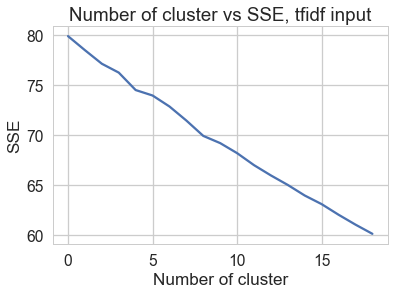

In [200]:
# elbow plots with no dimensionality reduction

num_clusters  = range(1, 20)

km = [KMeans(n_clusters=i) for i in num_clusters]

sse_test = {}

for i in range(len(km)):
    kmeans = km[i].fit(tfs)
    sse_test[i] = kmeans.inertia_ 

plt.figure()
plt.plot(list(sse_test.keys()), list(sse_test.values()))
plt.title("Number of cluster vs SSE, tfidf input")
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

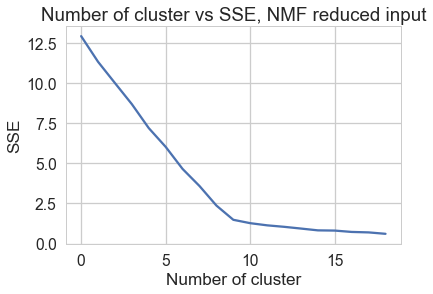

In [201]:
#  elbow plots using NMF for dimensionality reduction
num_clusters  = range(1, 20)

km = [KMeans(n_clusters=i) for i in num_clusters]

sse_test = {}

for i in range(len(km)):
    kmeans = km[i].fit(W_themes)
    sse_test[i] = kmeans.inertia_ 

plt.figure()
plt.plot(list(sse_test.keys()), list(sse_test.values()))
plt.title("Number of cluster vs SSE, NMF reduced input")
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [238]:
## Using num_clusters identified in model built on matrix with NMF dimensionality reduction

num_clusters = 9

km = KMeans(n_clusters=num_clusters, random_state=42)

km.fit(W_themes)

clusters = km.labels_.tolist()

In [239]:
from sklearn.externals import joblib

# pickle model
joblib.dump(km,  'doc_cluster.pkl')

#load pickled model
km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [240]:
# dictionary and df of episode content

episodes = { 'episodeID': list(puk.episodeID), 'episode_location': list(puk.episode_location), 
            'date': list(puk.air_date), 'cluster': clusters}

frame = pd.DataFrame(episodes, index = [clusters] , columns = ['episodeID', 'episode_location', 
                                                               'date', 'cluster'])

In [241]:
# print episodes in each cluster

#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    episode_list = []
   
    for episode in frame.loc[i]['episode_location']:
        episode_list.append(episode)
    print("Cluster {} episodes, {} episodes:  ".format(i, len(episode_list)))
    print(', '.join(episode_list))

    print('') #add whitespace
    print('') #add whitespace

Cluster 0 episodes, 2 episodes:  
Minas Gerais, Brazil, Bahia, Brazil


Cluster 1 episodes, 7 episodes:  
Cologne, Germany, Manila, Philippines, Trinidad, Rome, Uruguay, Cajun Mardi Gras, Buenos Aires


Cluster 2 episodes, 19 episodes:  
Miami, Detroit, Los Angeles, Queens, New Jersey, Chicago, Berlin, Colombia, Mississippi Delta, Los Angeles, Bay Area, The Bronx, Nashville, Massachusetts, Houston, Cuba, Pittsburgh, Seattle, South Africa


Cluster 3 episodes, 11 episodes:  
Tangier, Morocco, Quebec, Newfoundland, Lyon, France, Peru, Charleston, S.C., Marseille, London, French Alps, Copenhagen, Sicily


Cluster 4 episodes, 23 episodes:  
Senegal, Scotland, Montana, Tbilisi, Georgia, Madagascar, Antarctica, Oman, Punjab, India, West Virginia, Las Vegas, Russia, Mexico City, Myanmar, Armenia, Bhutan, Istanbul, Iran, Tanzania, Lagos, Nigeria, New Mexico, Jerusalem, Beirut, Sri Lanka


Cluster 5 episodes, 10 episodes:  
Laos, Korea, Thailand, Hong Kong, Shanghai, Hanoi, Vietnam, Borneo, Sic

In [280]:
#set up colors per clusters using a dict
cluster_colors = {0: '#46f0f0', 1: '#f032e6', 2: '#bcf60c', 3: '#fabebe', 4: '#008080',
                 5:'#e6194b', 6:'#3cb44b', 7:'#ffe119', 8:'#4363d8'}

#set up cluster names using a dict
cluster_names = {0:'brazil',
                 1:'random',
                 2:'us_cities_race',
                 3:'chef_travels',
                 4:'conflict_places', 
                 5:'asia',
                 6:'japan',
                 7:'random2',
                 8:'islands_med'}

## Plotting K means model clusters

After naming the location clusters generated by the KMeans model I plotted the clusters to get a visual sense of the clustering. The below plotting code is adapted from this [blog](http://brandonrose.org/clustering#Tf-idf-and-document-similarity). Compared to the clusters generated from the KMeans model without dimensionality reduction (data not shown, see [here](https://github.com/katherinechandler/puk_nlp/blob/master/parts_unknown_nlp_full.ipynb) ) these clusters are well defined. 

For the most part the clusters refect recognizable relationships between locations, but the NMF model is a better fit for identifying broad themes across episodes. Each episode is really a collection of themes, not a single theme, and the KMeans model doesn't reflect the different facets of these locations.

In [281]:
from sklearn.manifold import MDS

# make 2-d matrix for plotting

dist = 1 - cosine_similarity(W_themes)

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

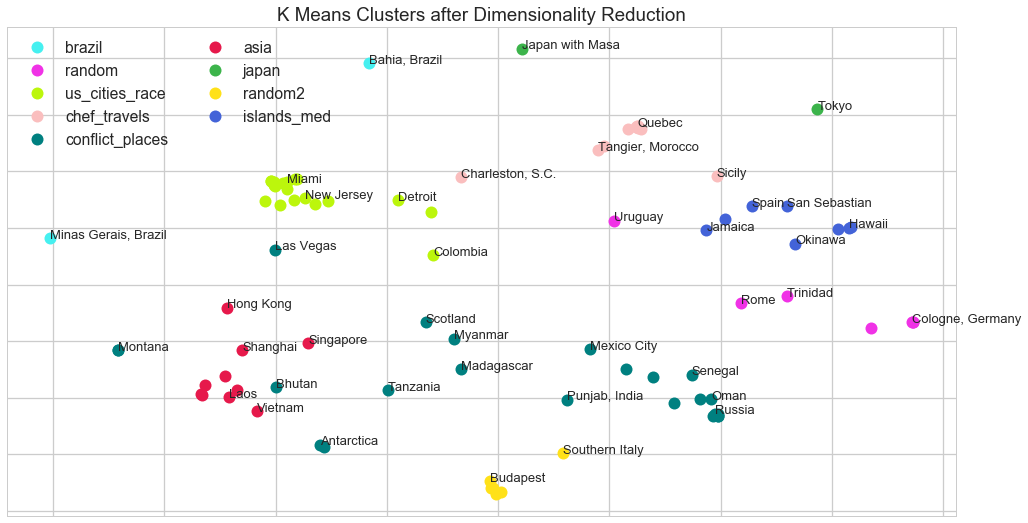

In [288]:
# example from http://brandonrose.org/clustering#Tf-idf-and-document-similarity
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=list(puk.episode_location))) 

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1, loc="upper left", ncol=2)  #show legend with only 1 point

# mask overlapping labels

ann = []
for i in range(len(df)):
    ann.append(ax.annotate(df.iloc[i]['title'], xy = (df.iloc[i]['x'], df.iloc[i]['y']), size=13))

mask = np.zeros(fig.canvas.get_width_height(), bool)

fig.canvas.draw()

for a in ann:
    bbox = a.get_window_extent()
    x0 = int(bbox.x0)
    x1 = int(math.ceil(bbox.x1))
    y0 = int(bbox.y0)
    y1 = int(math.ceil(bbox.y1))

    s = np.s_[x0:x1+1, y0:y1+1]
    if np.any(mask[s]):
        a.set_visible(False)
    else:
        mask[s] = True  
        
plt.title("K Means Clusters after Dimensionality Reduction")
plt.show()

In [289]:
plt.close()

## So what’s it all about, Tony???

*Parts Unknown* is frequently described as a ‘food show’, but it’s more than that. Yes, there is a strong food theme (Asian and otherwise) in these models, but this analysis shows what most fans of *Parts Unknown* inherently knew. The show is not *only* about food, but is an exploration of the human experience and the forces that shape the world we live in. 

Because each episode is really a mixture of themes and words I think that the generalized NMF model best describes the essence of the *Parts Unknown* corpus. Sifting through the most significant words for each theme and the episode scores by theme, the universality of these themes emerges.  The ‘conflict_areas’ theme explores broad themes of war and political uncertainty, ranging from Putin’s Russia to the politics of Hezbollah to ethnic conflict in Sri Lanka. The ‘music_art’ theme touches on emerging music scenes, the work of authors like William Faulkner and William S. Burrows, and the influence of gentrification on the arts. The ‘drugs’ theme links seemingly disparate places like Colombia, Massachusetts, and Morocco. Understanding connections between places that seem to have no business together is why I travel, and it’s something Bourdain did uniquely well.

So what’s it all about? Everything, I guess.

## And now some fun planning my next vacation: the conflict-foodie index

>###  “I usually try to avoid clean, orderly countries without massive social problems.” 
>###    -Anthony Bourdain

I couldn't agree more. Clean countries are boring (except Japan), orderly countries are boring (except Japan), and massive social problems often stem from cultural complexity. In this vein, I used the themes I uncovered in *Parts Unknown* to identify place I'd like to go. While I like conflict zones, I also like to eat, so I defined `interesting_places` as those that had non-zero scores for the `conflict_area` topic and the `foodie` topic. Below I plotted a heat map of the top `interesting_places` correlated with whether or not I have already visited (1= have been, 0= have not been). 

As per my strong suspicions, my next travel destination should be Iran, or possibly Oman (which I hear has some glamping opportunities). As always, Tony, thank you for the insight, and for encouraging people like me to venture forth and explore the big scary world.

In [299]:
# add my travel data to the episode scores data

combined_data = pd.merge(episode_scores, puk, left_index=True, right_on='episode_location')
combined_data = combined_data[list(episode_scores.columns) + ['episode_location', 'j_j']]
combined_data.columns = list(combined_data.columns[:-1]) + ['have_been']

combined_data.set_index('episode_location', inplace=True)

In [321]:
# the foodie topic index

interesting_places = (combined_data[['conflict_areas', 'foodie', 'have_been']]
                      [(combined_data.conflict_areas != 0)&(combined_data.foodie !=0)]).sort_values(by=
                                                         ['conflict_areas', 'foodie'], 
                                                         ascending=False).head(n=10)

In [322]:
# convert Y/N to int

mapping = {'Y': 1, 'N': 0}
interesting_places = interesting_places.applymap(lambda s: mapping.get(s) if s in mapping else s)

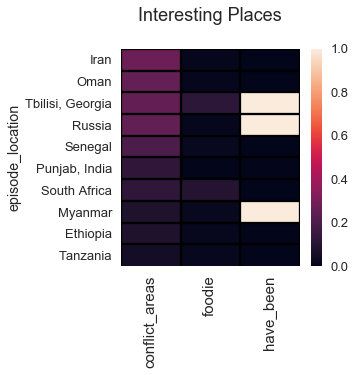

In [327]:
sns.set_context(context='talk', font_scale=1)
plt.figure(figsize=(4,4))
ax = sns.heatmap(interesting_places)
ax.hlines([range(len(interesting_places))], *ax.get_xlim())
ax.vlines([range(10)], *ax.get_ylim())
plt.title('Interesting Places', size=18, y=1.1)
plt.ylabel = ("Location")
plt.setp(ax.get_xticklabels(), rotation=90, size=15)

plt.show()